# Bad Discretizations for 2D Stokes

Copyright (C) 2020 Andreas Kloeckner

<details>
<summary>MIT License</summary>
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
</details>
----

Follows [Braess](https://doi.org/10.1017/CBO9780511618635), Section III.7.

**Of note:** This notebook contains a recipe for how to compute negative Sobolev norms, in one of the folds in part II, below.

(Thanks to [Colin Cotter](https://www.imperial.ac.uk/people/colin.cotter) and [Matt Knepley](https://cse.buffalo.edu/~knepley/) for tips!)

In [1]:
import numpy as np
import numpy.linalg as la
import firedrake.mesh as fd_mesh
import matplotlib.pyplot as plt

from firedrake import *

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


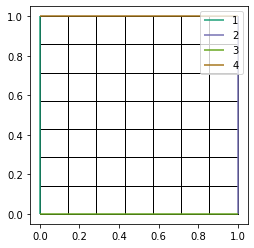

In [2]:
nx = 7
mesh = UnitSquareMesh(nx, nx, quadrilateral=True)

triplot(mesh)
plt.gca().set_aspect("equal")
plt.legend()

## Part I: The Checkerboard Instability

$\let\b=\boldsymbol$Build a $Q^1$-$Q^0$ mixed space:

In [3]:
V = VectorFunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)

Z = V * W

In [4]:
x = SpatialCoordinate(mesh)
x_w = interpolate(x[0], W)
y_w = interpolate(x[1], W)

In [5]:
x_array = x_w.dat.data.copy()
y_array = y_w.dat.data.copy()

x_idx = (np.round(x_array * nx * 2) - 1)//2
y_idx = (np.round(y_array * nx * 2) - 1)//2
                  
checkerboard = (x_idx+y_idx) % 2 - 0.5

q = Function(W, checkerboard)

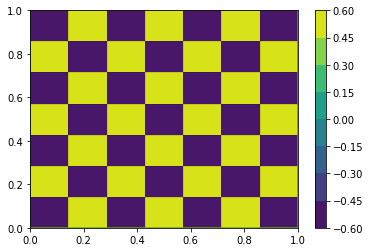

In [6]:
ax = plt.gca()
l = tricontourf(q, axes=ax)
triplot(mesh, axes=ax, interior_kw=dict(alpha=0.05))
plt.colorbar(l)

Assemble the discrete coefficients representing $\int (\nabla \cdot \boldsymbol u) q$:

In [7]:
utest, ptest = TestFunctions(Z)
bcs = [DirichletBC(Z.sub(0), Constant((0, 0)), (1, 2, 3, 4))]
coeffs = assemble(div(utest)*q*dx, bcs=bcs)
coeffs.dat.data[0].round(5).T

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
         0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,
        -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
         0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
         0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,
        -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Is this bad news?

$$b (\b{v}, q) = \int_{\Omega} \nabla \cdot \b{v}q.$$

Needed:

> There exists a constant $c_2 > 0$ so that (*inf-sup* or *LBB condition*):
> $$ \inf_{\mu \in M} \sup_{v \in X} \frac{b (v, \mu)}{||v||_X ||\mu||_M} \geqslant c_2 .$$

## Part II: Is Removing the Checkerboard Sufficient?

Suppose we consider the space that has the checkerboard projected out. Is that better?

[-3.  2.  3. -1. -2. -3. -0.  1.  2.  3.  1.  0. -1. -2. -3. -2. -1. -0.
  1.  2.  3.  3.  2.  1.  0. -1. -2. -3. -3. -2. -1. -0.  1.  2.  3.  2.
  1.  0. -1. -3. -2. -1. -0.  3.  2.  1. -3. -2.  3.]


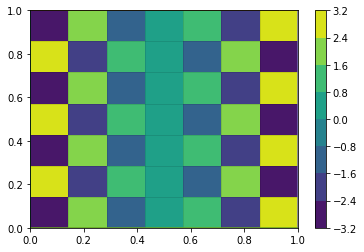

In [8]:
ramp_checkers = (x_idx-(nx//2))*(-1)**(x_idx+y_idx)
print(ramp_checkers)

q_ramp = Function(W, ramp_checkers)

ax = plt.gca()
l = tricontourf(q_ramp, axes=ax)
triplot(mesh, axes=ax, interior_kw=dict(alpha=0.05))
plt.colorbar(l)

Check that this new function `q_ramp` is orthogonal to the checkerboard `q`:

In [9]:
#clear
assemble(q_ramp*q*dx)

-5.204170427930421e-17

We would like to computationally check whether the inf-sup condition is obeyed.

> There exists a constant $c_2 > 0$ so that (*inf-sup* or *LBB condition*):
> $$ \inf_{\mu \in M} \sup_{v \in X} \frac{b (v, \mu)}{\|v\|_X \|\mu\|_M} \geqslant c_2 .$$

What are the $X$ and $M$ norms?
<details style="background-color: #ddd">
<summary>Show answer</summary>
$\|\cdot\|_X=\|\cdot\|_{H^1}$ and $\|\cdot\|_M=\|\cdot\|_L^2$.
</details>

How do we check the inf-sup condition?
<details style="background-color: #ddd">
<summary>Show answer</summary>
We're choosing a specific $\mu$ (=`q`) here, so we need to check that a (mesh-independent
$$ \sup_{v \in X} \frac{b (v, \mu)}{\|v\|_X }
=\sup_{v \in H^1} \frac{b (v, \mu)}{\|v\|_{H^1} } \ge c_2  \|\mu\|_{L^2}
$$
So we should really be computing the $H^{-1}$ norm of the functional $b(\cdot, \mu)$.
</details>

How do we evaluate that quantity?
<details style="background-color: #ddd">
<summary>Show answer</summary>
Find the $(H^1)^2$ Riesz representer $\b u$ of $f(\b v):=b(\b v, \mu)$, i.e. $\b u$ so that
$$(\b u,\b v)_{(H^1)^2} = b(\b v, \mu) \qquad(\b v\in (H^1_0)^2).$$
Then, evaluate $\|u\|_{(H^1)^2}$.

This works because
$$
\|f\|_{H^{-1}}
=\sup_{v\in H^1}\frac{|f(v)|}{\|v\|_{H^1}}
=\sup_{v\in H^1}\frac{|(u,v)|_{H^1}}{\|v\|_{H^1}}
=\|u\|_{H^1}.
$$
Equivalently, we may evaluate $\sqrt{f(u)}=\sqrt{(u,u)_{H^1}}  =\|u\|_{H^1}$.
</details>

Write a function with arguments <tt>(V, q)</tt> to evaluate that quantity.

In [10]:
#clear
def hminus1_norm(V, q):
    # Evaluates the H^{-1} norm of b, where V is
    # the function space for the first argument.
    
    u = TrialFunction(V)
    v = TestFunction(V)
    
    riesz_rep = Function(V)
    solve((inner(grad(u), grad(v)) + inner(u,v))*dx == div(v)*q*dx, riesz_rep)
    
    return norm(riesz_rep, "H1")

In [11]:
h_values = []
h1_norms = []

for e in range(6):
    nx = 10 * 2**e - 1
    print(f"Now computing nx={nx}...")
    mesh = UnitSquareMesh(nx, nx, quadrilateral=True)
    
    V = VectorFunctionSpace(mesh, "CG", 1)
    W = FunctionSpace(mesh, "DG", 0)

    Z = V * W
    
    x = SpatialCoordinate(mesh)
    x_w = interpolate(x[0], W)
    y_w = interpolate(x[1], W)
    
    x_array = x_w.dat.data.copy()
    y_array = y_w.dat.data.copy()

    x_idx = (np.round(x_array * nx * 2) - 1)//2
    y_idx = (np.round(y_array * nx * 2) - 1)//2
    
    odd_checkers = (x_idx-(nx//2))*(-1)**(x_idx+y_idx)
    q_ramp = Function(W, odd_checkers)
    
    h_values.append(1/nx)
    h1_norms.append(hminus1_norm(V, q_ramp)/norm(q_ramp, "L2"))

Now computing nx=9...
Now computing nx=19...
Now computing nx=39...
Now computing nx=79...
Now computing nx=159...
Now computing nx=319...


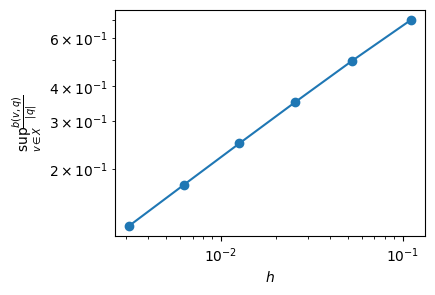

In [12]:
plt.figure(figsize=(4,3), dpi=100)
plt.loglog(h_values, h1_norms, "o-")
plt.xlabel("$h$")
z = plt.ylabel(r"$\sup_{v\in X}\frac{b(v,q)}{\|q\|}$")

What does this mean?

<details style="background-color: #ddd">
<summary>Show answer</summary>
Since, apparently,
$$\sup_{v \in X} \frac{b (v, \mu)}{\|v\|_X \|\mu\|_M} =O(h)$$
as $h\to 0$, there cannot be a mesh-independent lower bound $c_2$ for this quantity. A discrete inf-sup condition does not hold for this discretization.
</details>

Matt Knepley added this follow-up: (on the Firedrake Slack channel):

> You can also see the instability by looking at the condition number of the Schur complement of the full system, which grows with N.
>
>  There's also the ASCOT approach (Automated testing of saddle point stability conditions in the [FEniCS book](https://fenicsproject.org/book/)). [Florian Wechsung] forward-ported that code to Firedrake. Additionally in the case of the Stokes problem, see this nice paper: https://www.waves.kit.edu/downloads/CRC1173_Preprint_2017-15.pdf

Note that none of these approaches require manually identifying the problematic functions.